# ABOUT

In this project of the Data Analyst Nanodegree, the "Wrangle & Analyze Data" project, you are required to wrangle (gather, assess, & clean), analyze and visualize data obtained from 3 sources: 

1. Tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent". WeRateDogs has over 4 million followers and has received international media coverage.

2. Tweet Image Predictions File
Every image in the WeRateDogs Twitter archive was run through a neural network that can classify breeds of dogs. The results: a table full of the top three image predictions alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

3. Additional Data via the Twitter API
Because you have the tweet IDs of WeRateDogs Twitter archive you will be able to gather retweet count, favorite count and any additional data you find interesting for all available tweets. The Twitter API requires users to be authorized to use it. This means that before you can run your API querying code, you need to set up your own Twitter developer account. If you can't set up a Twitter developer account, or you prefer not to create a Twitter account for some reason, you may instead use tweet_json.txt (provided by Udacity) that contains the resulting data from querying Twitter API then read this tweet_json.txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count."

At the end, all steps should be documented in 2 reports; Wrangle report (describes wrangling process) & Act report (displays visuals and insights)

### IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import requests
import tweepy
import os
import json
import datetime
import numpy as np
import string
import re
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-2-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# (1) DATA GATHERING

### (A) Twitter archive data

In [3]:
archive_df = pd.read_csv("twitter_archive_enhanced.csv")

### (B) Image predictions data

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, allow_redirects=True)
open('image_predictions.tsv', 'wb').write(r.content)
predictions_df = pd.read_csv("image_predictions.tsv", sep = "\t")

### (C) Twitter API data

In [5]:
consumer_key = '*****'
consumer_secret = '*****'
access_token = '*****'
access_secret = '*****'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

errors = []
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in archive_df['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
                #print(status)
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

df_list = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
df_list
twitter_df = pd.DataFrame(df_list)

# (2) DATA ASSESSMENT

Assessing is done visually and programmatically. 
The goal is to find 8 quality issues and 2 tidiness issues.

### (A) Assessing Twitter archive data

In [6]:
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [7]:
archive_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
2006,672267570918129665,NaN,NaN,2015-12-03 04:14:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you accidentally open up the front facing camera. 10/10 https://t.co/jDXxZARQIZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672267570918129665/photo/1,10,10,None,None,None,None,None
1400,699446877801091073,NaN,NaN,2016-02-16 04:15:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Archie. He's undercover in all these pics. Not actually a bee, cow, or Hawaiian. Sneaky af. 12/10 https://t.co/9fojElzIxx",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/699446877801091073/photo/1,https://twitter.com/dog_rates/status/699446877801091073/photo/1,https://twitter.com/dog_rates/status/699446877801091073/photo/1",12,10,Archie,None,None,None,None
738,780800785462489090,NaN,NaN,2016-09-27 16:06:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Koda. He has a weird relationship with tall grass. Slightly concerning. 11/10 would def still pet https://t.co/KQzSR8eCsw,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/780800785462489090/photo/1,https://twitter.com/dog_rates/status/780800785462489090/photo/1,https://twitter.com/dog_rates/status/780800785462489090/photo/1",11,10,Koda,None,None,None,None
1266,709852847387627521,NaN,NaN,2016-03-15 21:24:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",*lets out a tiny whimper and then collapses* ...12/10 https://t.co/BNdVZEHRow,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/709852847387627521/photo/1,https://twitter.com/dog_rates/status/709852847387627521/photo/1,https://twitter.com/dog_rates/status/709852847387627521/photo/1,https://twitter.com/dog_rates/status/709852847387627521/photo/1",12,10,None,None,None,None,None
1488,692919143163629568,NaN,NaN,2016-01-29 03:56:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please only send in dogs. Don't submit other things like this pic of Kenny Chesney in a bathtub. Thank you. 9/10 https://t.co/TMpDHHGspy,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692919143163629568/photo/1,9,10,None,None,None,None,None
1415,698703483621523456,NaN,NaN,2016-02-14 03:01:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rusty. He has no respect for POULTRY products. Unbelievable af. 7/10 would still pet https://t.co/hEH19t1eFp,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698703483621523456/photo/1,7,10,Rusty,None,None,None,None
1280,708834316713893888,NaN,NaN,2016-03-13 01:57:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Malikai. He was rolling around having fun when he remembered the inevitable heat death of the universe. 10/10 https://t.co/Vd2FqHIIGn,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708834316713893888/photo/1,10,10,Malikai,None,None,None,None
441,819711362133872643,NaN,NaN,2017-01-13 01:03:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Howie. He just bloomed. 11/10 revolutionary af https://t.co/m5fYxrO3IU,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/8197113

In [8]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
archive_df.rating_numerator.describe()

count    2356.000000
mean     13.126486  
std      45.876648  
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      1776.000000
Name: rating_numerator, dtype: float64

In [11]:
archive_df.rating_denominator.describe()

count    2356.000000
mean     10.455433  
std      6.745237   
min      0.000000   
25%      10.000000  
50%      10.000000  
75%      10.000000  
max      170.000000 
Name: rating_denominator, dtype: float64

In [12]:
archive_df.name.value_counts().head(10)

None       745
a          55 
Charlie    12 
Oliver     11 
Cooper     11 
Lucy       11 
Lola       10 
Tucker     10 
Penny      10 
Winston    9  
Name: name, dtype: int64

In [13]:
archive_df.in_reply_to_status_id.isnull().value_counts()

True     2278
False    78  
Name: in_reply_to_status_id, dtype: int64

In [14]:
archive_df.retweeted_status_id.isnull().value_counts()

True     2175
False    181 
Name: retweeted_status_id, dtype: int64

### (B) Assessing Image predictions data

In [15]:
predictions_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [16]:
predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
417,674024893172875264,https://pbs.twimg.com/media/CVqeEKLW4AA1wXH.jpg,1,Pomeranian,0.648500,True,Pekinese,0.339835,True,Persian_cat,0.006448,False
1471,779377524342161408,https://pbs.twimg.com/ext_tw_video_thumb/779377444025499652/pu/img/eIiLDy9F6rPNarEc.jpg,1,sundial,0.170921,False,cash_machine,0.060359,False,maze,0.054981,False
577,678740035362037760,https://pbs.twimg.com/media/CWtede2WIAAF_AJ.jpg,1,seat_belt,0.787164,False,sunglasses,0.045739,False,beagle,0.022525,True
1956,864873206498414592,https://pbs.twimg.com/media/DAClmHkXcAA1kSv.jpg,2,pole,0.478616,False,lakeside,0.114182,False,wreck,0.055926,False
592,679462823135686656,https://pbs.twimg.com/media/CW3v1KxW8AAIOuy.jpg,1,toy_poodle,0.621780,True,miniature_poodle,0.197819,True,soft-coated_wheaten_terrier,0.046745,True


In [17]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
predictions_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### (C) Assessing Twitter API data

In [19]:
twitter_df.head(5)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7386,35089
1,892177421306343426,5499,30375
2,891815181378084864,3635,22840
3,891689557279858688,7560,38365
4,891327558926688256,8145,36641


In [20]:
twitter_df.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2330 non-null   int64
 1   retweet_count   2330 non-null   int64
 2   favorite_count  2330 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


# Assessing results.

### Tidiness.

* Merge all three datframes together onto one `df`
* `df` has values as column names (doggo, pupper, floofer, puppo).


### Quality.

#### `df` dataframe.
* timestamp is an object instead of datetime.
* Unwanted enteries that do not contain images.
* Unwanted enteries that are retweets or replies.
* Tweet id is an int instead of a string.
* Ratings are extracted wrong when the numerator is a fraction. (ex: 15.5/10 is 5/10)
* Missing ratings from original tweets.
* Invalid rating for pictures of multiple dogs.
* Inaccurate parsed ratings that are actually correct but do not follow the specified schema. (ex 1776/10 & 420/10)
* Rating extracted wrong when it's the second fraction in a tweet. (ex: tweet at index 20)
* Wrongly extracted / missing names.
* Missing dogs names are "None" instead of NaN
* Date and time are in the same columns in the `master_df`.
* Some dog names start with uppercase, and other with lowercase.

* `predictions_df` can be reshaped for better clarifications using wide_to_long, also only the first level is relevant in my analysis.




# (3) DATA CLEANING

Define > Code > Test > Iterate

### Making copies of the original dataframe to clean

In [21]:
archive_df_copy = archive_df.copy()
predictions_df_copy = predictions_df.copy() 
twitter_df_copy = twitter_df.copy()

## Define
* Reshape the `predictions_df_copy` dataframe.

## Code

In [22]:
predictions_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
# Renaming the dataset columns
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
predictions_df_copy.columns = cols

predictions_df_copy = pd.wide_to_long(predictions_df_copy, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

## Test

In [24]:
predictions_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          6225 non-null   int64  
 1   jpg_url           6225 non-null   object 
 2   img_num           6225 non-null   int64  
 3   prediction_level  6225 non-null   int64  
 4   prediction        6225 non-null   object 
 5   confidence        6225 non-null   float64
 6   breed             6225 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 298.0+ KB


## Define
* Merge `archive_df` and `twitter_df` api using the enteries in `predictions_df_copy` df.

## Code

In [25]:
df = predictions_df.merge(archive_df_copy, how = 'left', on = 'tweet_id')
master_df = df.merge(twitter_df, how = 'left', on = 'tweet_id')

## Test

In [26]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   jpg_url                     2075 non-null   object 
 2   img_num                     2075 non-null   int64  
 3   p1                          2075 non-null   object 
 4   p1_conf                     2075 non-null   float64
 5   p1_dog                      2075 non-null   bool   
 6   p2                          2075 non-null   object 
 7   p2_conf                     2075 non-null   float64
 8   p2_dog                      2075 non-null   bool   
 9   p3                          2075 non-null   object 
 10  p3_conf                     2075 non-null   float64
 11  p3_dog                      2075 non-null   bool   
 12  in_reply_to_status_id       23 non-null     float64
 13  in_reply_to_user_id         23 no

### Drop the predictions columns as we do not need them anymore.

In [27]:
master_df.drop(columns = ['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace = True)

## Test

In [28]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  doggo                       2075 

## Define
* Merge 4 dog stages columns in one column "dog_stage"

## Code

In [29]:
#master_df['dog_stage'] = master_df.text.str.extract('(doggo|floofer|pupper|puppo)')

In [30]:
#master_df = master_df.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'])

In [31]:
# handle none
master_df.doggo.replace('None', '', inplace=True)
master_df.floofer.replace('None', '', inplace=True)
master_df.pupper.replace('None', '', inplace=True)
master_df.puppo.replace('None', '', inplace=True)

# merge into column
master_df['dog_stage'] = master_df.doggo + master_df.floofer + master_df.pupper + master_df.puppo

# handle multiple stages
master_df.loc[master_df.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
master_df.loc[master_df.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
master_df.loc[master_df.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

# handle missing values
master_df.loc[master_df.dog_stage == '', 'dog_stage'] = np.nan
master_df.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace = True)

## Test

In [32]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  retweet_count               2058 

In [33]:
master_df.dog_stage.isnull()

0       True
1       True
2       True
3       True
4       True
        ... 
2070    True
2071    True
2072    True
2073    True
2074    True
Name: dog_stage, Length: 2075, dtype: bool

## Define
* fix timestamp format in `master_df` - extract info from timestamp into two new columns (`time` and `date`)

## Code

In [34]:
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])

In [35]:
master_df['date'] = master_df.timestamp.dt.date

In [36]:
master_df['time'] = master_df.timestamp.dt.time

In [37]:
master_df.drop(columns = ['timestamp'], inplace = True)

## Test

In [38]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   source                      2075 non-null   object 
 4   text                        2075 non-null   object 
 5   retweeted_status_id         81 non-null     float64
 6   retweeted_status_user_id    81 non-null     float64
 7   retweeted_status_timestamp  81 non-null     object 
 8   expanded_urls               2075 non-null   object 
 9   rating_numerator            2075 non-null   int64  
 10  rating_denominator          2075 non-null   int64  
 11  name                        2075 non-null   object 
 12  retweet_count               2058 non-null   float64
 13  favorite_count              2058 

## Define
* Dropping replies & retweets entries from the `master_df`.

## Code

In [39]:
retweet_enteries = master_df.retweeted_status_id.notnull() 
master_df = master_df[~retweet_enteries]
reply_enteries = master_df.in_reply_to_status_id.notnull() 
master_df = master_df[~reply_enteries]

## Test

In [40]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1971 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   source                      1971 non-null   object 
 4   text                        1971 non-null   object 
 5   retweeted_status_id         0 non-null      float64
 6   retweeted_status_user_id    0 non-null      float64
 7   retweeted_status_timestamp  0 non-null      object 
 8   expanded_urls               1971 non-null   object 
 9   rating_numerator            1971 non-null   int64  
 10  rating_denominator          1971 non-null   int64  
 11  name                        1971 non-null   object 
 12  retweet_count               1963 non-null   float64
 13  favorite_count              1963 

## Define
* Dropping replies & retweets columns from the `master_df`.

## Code

In [41]:
master_df.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace = True)

## Test

In [42]:
master_df.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'dog_stage', 'date', 'time'],
      dtype='object')

# Test both dataframes

In [43]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   source              1971 non-null   object 
 2   text                1971 non-null   object 
 3   expanded_urls       1971 non-null   object 
 4   rating_numerator    1971 non-null   int64  
 5   rating_denominator  1971 non-null   int64  
 6   name                1971 non-null   object 
 7   retweet_count       1963 non-null   float64
 8   favorite_count      1963 non-null   float64
 9   dog_stage           303 non-null    object 
 10  date                1971 non-null   object 
 11  time                1971 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 200.2+ KB


In [44]:
predictions_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          6225 non-null   int64  
 1   jpg_url           6225 non-null   object 
 2   img_num           6225 non-null   int64  
 3   prediction_level  6225 non-null   int64  
 4   prediction        6225 non-null   object 
 5   confidence        6225 non-null   float64
 6   breed             6225 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 298.0+ KB


## Define
* change tweet id from int to object in both datasets

## Code

In [45]:
master_df.tweet_id = master_df.tweet_id.astype(str)

In [46]:
predictions_df_copy.tweet_id = predictions_df_copy.tweet_id.astype(str)

## Test

In [47]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   object 
 1   source              1971 non-null   object 
 2   text                1971 non-null   object 
 3   expanded_urls       1971 non-null   object 
 4   rating_numerator    1971 non-null   int64  
 5   rating_denominator  1971 non-null   int64  
 6   name                1971 non-null   object 
 7   retweet_count       1963 non-null   float64
 8   favorite_count      1963 non-null   float64
 9   dog_stage           303 non-null    object 
 10  date                1971 non-null   object 
 11  time                1971 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 200.2+ KB


In [48]:
predictions_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          6225 non-null   object 
 1   jpg_url           6225 non-null   object 
 2   img_num           6225 non-null   int64  
 3   prediction_level  6225 non-null   int64  
 4   prediction        6225 non-null   object 
 5   confidence        6225 non-null   float64
 6   breed             6225 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 298.0+ KB


## Define
* In `predictions_df_copy` df, make all dogs name lowercase

## Code

In [49]:
master_df.prediction = predictions_df_copy.prediction.apply(lambda x: x.lower())

<ipython-input-49-f24affbe872d>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  master_df.prediction = predictions_df_copy.prediction.apply(lambda x: x.lower())


## Test

In [50]:
predictions_df_copy.head(10)

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True
5,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,3,Rhodesian_ridgeback,0.072010,True
6,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,1,German_shepherd,0.596461,True
7,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,2,malinois,0.138584,True
8,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,3,bloodhound,0.116197,True
9,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,1,Rhodesian_ridgeback,0.408143,True


## Define
* Fix fractions issue

## Code

In [51]:
master_df['rating_numerator'] = master_df.text.str.extract('(\d+\.?\d?\d?)\/\d{1,3}', expand = False).astype('float')

## Test

In [52]:
master_df.loc[(master_df.rating_numerator > 15), ['tweet_id', 'rating_numerator', 'rating_denominator', 'text']]

,tweet_id,rating_numerator,rating_denominator,text
277,670842764863651840,420.0,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
501,675853064436391936,88.0,80,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
560,677716515794329600,144.0,120,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
692,684222868335505415,121.0,110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
865,697463031882764288,44.0,40,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
941,704054845121142784,60.0,50,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1007,709198395643068416,45.0,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1025,710658690886586372,80.0,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1050,713900603437621249,99.0,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1071,716439118184652801,50.0,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq


## Define
* fix tweet at index 1658 with no original rating by setting numerator and denominator it to NaN

## Code

In [53]:
master_df.loc[1658, 'rating_denominator'] = np.NaN
master_df.loc[1658, 'rating_numerator'] = np.NaN

## Test

In [54]:
master_df.at[1658, 'rating_numerator']

nan

In [55]:
master_df.at[1658, 'rating_denominator']

nan

## Define
* fixing the pack of dogs issues.

## Code

In [56]:
master_df.loc[(master_df.rating_denominator != 10), ['tweet_id', 'rating_numerator', 'rating_denominator', 'text']]

,tweet_id,rating_numerator,rating_denominator,text
20,666287406224695296,1.0,2.0,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
501,675853064436391936,88.0,80.0,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
560,677716515794329600,144.0,120.0,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
667,682962037429899265,7.0,11.0,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
692,684222868335505415,121.0,110.0,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
865,697463031882764288,44.0,40.0,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
941,704054845121142784,60.0,50.0,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1007,709198395643068416,45.0,50.0,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1025,710658690886586372,80.0,80.0,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1050,713900603437621249,99.0,90.0,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1


In [57]:
# Calculating the dogs counts in the tweets featuring many dogs
dogs_count = master_df.rating_denominator[master_df.rating_numerator >= 40]/10
print(dogs_count)
master_df.loc[master_df.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [master_df.rating_numerator[master_df.rating_numerator >= 40]/dogs_count , 10]

277     1.0 
501     8.0 
560     12.0
692     11.0
865     4.0 
941     5.0 
1007    5.0 
1025    8.0 
1050    9.0 
1071    5.0 
1148    17.0
1270    1.0 
1338    15.0
1728    7.0 
Name: rating_denominator, dtype: float64


C:\Users\neils\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Test

In [58]:
master_df.loc[(master_df.rating_denominator != 10 )]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage,date,time
20,666287406224695296,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1.0,2.0,an,57.0,131.0,NaN,2015-11-16,16:11:11
667,682962037429899265,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7.0,11.0,Darrel,15695.0,35357.0,NaN,2016-01-01,16:30:13
1105,722974582966214656,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4.0,20.0,None,1497.0,3946.0,NaN,2016-04-21,02:25:47
1196,740373189193256964,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9.0,11.0,None,12748.0,33788.0,NaN,2016-06-08,02:41:38
1658,810984652412424192,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",NaN,NaN,Sam,1404.0,5246.0,NaN,2016-12-19,23:06:23


## Define
* Fix the wrong parsed first fraction as rating instead of second manually.

## Code

In [59]:
master_df.loc[20, 'rating_numerator'] = 9
master_df.loc[20, 'rating_denominator'] = 10

master_df.loc[667, 'rating_numerator'] = 10
master_df.loc[667, 'rating_denominator'] = 10

master_df.loc[1105, 'rating_numerator'] = 13
master_df.loc[1105, 'rating_denominator'] = 10

master_df.loc[1196, 'rating_numerator'] = 14
master_df.loc[1196, 'rating_denominator'] = 10

## Test

In [60]:
master_df.loc[(master_df.rating_denominator != 10), ['tweet_id', 'rating_numerator', 'rating_denominator', 'text']]

,tweet_id,rating_numerator,rating_denominator,text
1658,810984652412424192,NaN,NaN,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx


## Define
* remove ratings of tweets at index 277 & 1658 (420 and 1776 as numerators) as they can mess up statistics

## Code

In [61]:
master_df.loc[277, 'rating_denominator'] = np.NaN
master_df.loc[277, 'rating_numerator'] = np.NaN
master_df.loc[1270, 'rating_denominator'] = np.NaN
master_df.loc[1270, 'rating_numerator'] = np.NaN

## Test

In [62]:
master_df.loc[(master_df.rating_numerator > 15), ['tweet_id', 'rating_numerator', 'rating_denominator', 'text']]

,tweet_id,rating_numerator,rating_denominator,text


In [63]:
master_df.loc[(master_df.rating_denominator != 10), ['tweet_id', 'rating_numerator', 'rating_denominator', 'text']]

,tweet_id,rating_numerator,rating_denominator,text
277,670842764863651840,NaN,NaN,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
1270,749981277374128128,NaN,NaN,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1658,810984652412424192,NaN,NaN,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx


## Define
* fix wrongly extracted names

## Code

In [64]:
master_df.name = master_df.name.astype(str)

In [65]:
name_pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in master_df.iterrows():  
    if (row['name'].islower()):
        try:
            new_name = re.findall(name_pattern, row['text'])[0]
            master_df.loc[index,'name'] = master_df.loc[index,'name'].replace(row['name'], new_name)
        except IndexError:
            master_df.loc[index,'name'] = np.nan

## Define
* some missing dog names are string "None" instead of nan

## Code

In [66]:
master_df.name = master_df.name.replace({"None": np.nan})

## Test

In [67]:
master_df.loc[:, 'name']

0       NaN     
1       NaN     
2       NaN     
3       NaN     
4       NaN     
       ...      
2070    Franklin
2071    Darla   
2072    Archie  
2073    Tilly   
2074    Phineas 
Name: name, Length: 1971, dtype: object

## Define
* Merge `master_df` and `predictions_df_copy` together for easier analysis.

## Code

In [68]:
predictions_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          6225 non-null   object 
 1   jpg_url           6225 non-null   object 
 2   img_num           6225 non-null   int64  
 3   prediction_level  6225 non-null   int64  
 4   prediction        6225 non-null   object 
 5   confidence        6225 non-null   float64
 6   breed             6225 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 298.0+ KB


In [69]:
predictions_df_copy = predictions_df_copy.query("prediction_level == 1")

In [70]:
predictions_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 6222
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2075 non-null   object 
 1   jpg_url           2075 non-null   object 
 2   img_num           2075 non-null   int64  
 3   prediction_level  2075 non-null   int64  
 4   prediction        2075 non-null   object 
 5   confidence        2075 non-null   float64
 6   breed             2075 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 115.5+ KB


In [71]:
df = master_df.merge(predictions_df_copy, how = 'left', on = 'tweet_id')

Dropping the predictions level column as they're all 1 now

In [72]:
df.drop(['prediction_level'], axis = 1, inplace = True)

## Test

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   object 
 1   source              1971 non-null   object 
 2   text                1971 non-null   object 
 3   expanded_urls       1971 non-null   object 
 4   rating_numerator    1968 non-null   float64
 5   rating_denominator  1968 non-null   float64
 6   name                1371 non-null   object 
 7   retweet_count       1963 non-null   float64
 8   favorite_count      1963 non-null   float64
 9   dog_stage           303 non-null    object 
 10  date                1971 non-null   object 
 11  time                1971 non-null   object 
 12  jpg_url             1971 non-null   object 
 13  img_num             1971 non-null   int64  
 14  prediction          1971 non-null   object 
 15  confidence          1971 non-null   float64
 16  breed 

# STORING

In [74]:
df.to_csv("twitter_archive_master.csv", index = False)

   # ANALYSIS & VISUALIZATIONS 

### Percentages of different dog stages

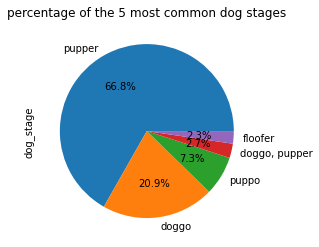

In [75]:
df.dog_stage.value_counts()[:5].plot(kind = 'pie', autopct = '%1.1f%%', fontsize = "10")
plt.title("percentage of the 5 most common dog stages")
plt.show()

### Percentages of different dog breeds

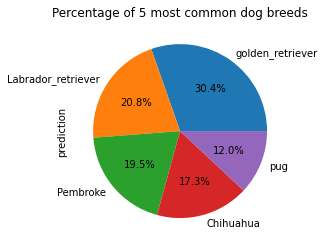

In [76]:
df.query("breed == True").prediction.sort_values().value_counts()[:5].plot(kind = 'pie', autopct = '%1.1f%%')
plt.title("Percentage of 5 most common dog breeds")
plt.show()

### Dog breed vs. Avg retweet count.

Text(0.5, 1.0, 'Retweets counts for different dog breeds.')

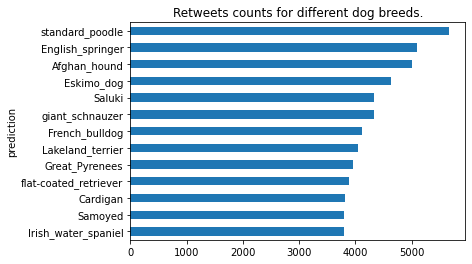

In [77]:
df.query("breed == True").groupby(['prediction']).retweet_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh')
plt.title("Retweets counts for different dog breeds.")

### Dog breed vs. Avg favorite count.

Text(0.5, 1.0, 'Favorite counts for different dog breeds.')

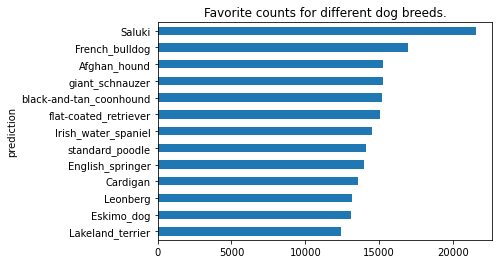

In [78]:
df.query("breed == True").groupby(['prediction']).favorite_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh')
plt.title("Favorite counts for different dog breeds.")

Text(0.5, 1.0, 'FAvorite counts for different dog stages.')

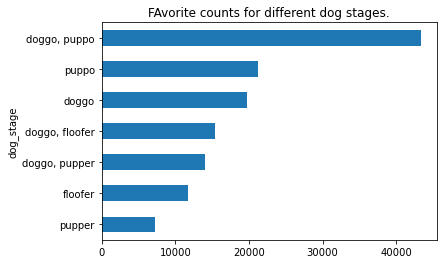

In [79]:
df.query("breed == True").groupby(['dog_stage']).favorite_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh')
plt.title("FAvorite counts for different dog stages.")

## Time Series Analysis

In [80]:
df_t = df.copy()

In [81]:
df_t.date = pd.to_datetime(df_t.date)

In [82]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   source              1971 non-null   object        
 2   text                1971 non-null   object        
 3   expanded_urls       1971 non-null   object        
 4   rating_numerator    1968 non-null   float64       
 5   rating_denominator  1968 non-null   float64       
 6   name                1371 non-null   object        
 7   retweet_count       1963 non-null   float64       
 8   favorite_count      1963 non-null   float64       
 9   dog_stage           303 non-null    object        
 10  date                1971 non-null   datetime64[ns]
 11  time                1971 non-null   object        
 12  jpg_url             1971 non-null   object        
 13  img_num             1971 non-null   int64       

In [83]:
df_t.index = df_t.date

In [84]:
df_t.drop(columns='date', inplace = True)

In [85]:
df_t.sort_index(inplace = True)

### Ratings imporvment over time.

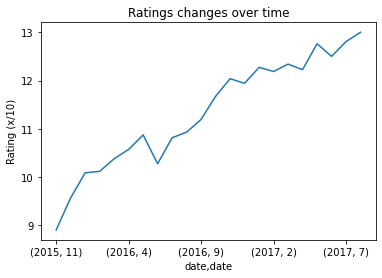

In [86]:
df_t.groupby([(df_t.index.year),(df_t.index.month)]).rating_numerator.mean().plot()
plt.title("Ratings changes over time")
plt.ylabel("Rating (x/10)")
plt.show()

In [87]:
df.groupby(['breed']).favorite_count.mean()

breed
False    7220.700787
True     8367.686598
Name: favorite_count, dtype: float64